## Creating a training/validation/test set from multiple Collect Earth projects

This tutorial demonstrates how several Collect Earth Online projects can be:

1. Recoded and reshaped into a structure more tractable for modeling; 
2. Merged into a single dataset that provide a single label for each sample point and an estimate of label uncertainty;
3. Split into training, validation, and test (or map reference) samples. 

The data used in this demonstration are the results of three Collect Earth Online projects that were captured over the Department of Ucayali, Peru. Each project represents the efforts of an individual (or group of individuals working in the same project) to label 1350 points, classifying each into 1 of 4 classes: not oil palm; young oil palm; mature oil palm;  unsure. The datasets preserve all the information from these projects. Users' email addresses were anonymized. 

## Set-up

This notebook uses a R kernel, set up using `conda` as follows:

```bash
(base) % conda create -n r_env r-essentials r-base
(base) % conda activate r_env
```

Followed by installing several packages
```bash
(r_env) % conda install -c conda-forge r-sf
(r_env) % install -c r r-catools
(r_env) % install -c conda-forge r-raster
(r_env) % install -c conda-forge r-geojsonio
```

### Packages

The following packages loads the primary packages used in this analysis. Functions from `raster` and `here` are also used via their namespaces. 

In [2]:
import_library = function(lib_name){
    suppressWarnings(suppressMessages(require(lib_name, character.only = TRUE)))
}
import_library('dplyr')
import_library('sf')
import_library('caTools')
import_library('ggplot2')

### Read-in, reshape, and recode classes
The first step was to combine the three datasets into a single dataset, with the columns from each of the three CEO projects, and to recode the four classes into a single column with values 0 (not oil palm),  1 (young oil palm), 2 (mature oil palm), 3 (unsure). At this step, we end up with 3 columns, 1 per completed CEO project: `cl1` = samples from project 1, `cl2` = samples from project 2, `cl3` = samples from project 3. Each column contains the recoded classes (note the renaming of the columns is done in the next code chunk). 

In [7]:
fs <- dir("data", full.names = TRUE, pattern = "ceo*.*user*.*")

# read datasets into list, keep the most important columns, and do some renaming
data_list <- lapply(fs, function(x) {
  dat <- readr::read_csv(x, col_types = readr::cols()) %>% 
    select(pl_plotid, pl_cluster, email, center_lon, center_lat, 
           contains("Oil")) %>% 
    rename(x = center_lon, y = center_lat, clust = pl_cluster) %>% 
    rename_at(vars(contains("Oil")), list(~gsub("Oil Palm|\\?\\:| ","", .))) %>% 
    mutate(class = case_when(
      Young == 100 ~ 1, 
      Mature == 100 ~ 2,
      Not == 100 ~ 0, 
      NotSure == 100 ~ 3
    )) %>% 
    rename(id = pl_plotid) %>% 
    select(id, clust, class)
})

# combine into single dataset, conttains just the plot id, the stratum (clust), 
# and the recoded classification columns from each input
sample_combined <- purrr::reduce(data_list, left_join, by = c("id", "clust"))
nms <- names(sample_combined)
nms[grep("class", nms)] <- paste0("cl", 1:length(grep("class", nms)))
names(sample_combined) <- nms
head(sample_combined)

id,clust,cl1,cl2,cl3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,2,NA
2,1,0,0,0
3,0,0,0,0
4,1,2,2,1
5,0,0,0,0
6,0,0,0,0


### Simplify the classes

In this step, a single classification is created by finding the modal class for each sample point across the 3 groups' results. This creates a new `class` column, which provides the class from the majority opinion. 

We repeat this same step again after first collapsing, within each of the `cl1:cl3` columns, the two oil palm classes into a single *oil palm* class with value = 1--*not oil palm* remains 0, and *unsure* remains 3. The modal function was re-run to create a new consensus class, called `class2`. We recommend that `class2` be used for modelling, while `class` may be useful for understanding error patterns. 

In [11]:
# reshape and assign class as most frequently occurring value
op_reclass <- function(x) {
  raster::modal(ifelse(x %in% 1:2, 1, x), na.rm = TRUE)
}
samples_red <- sample_combined %>% 
  rowwise() %>% 
  mutate(class = raster::modal(c_across(cl1:cl3), na.rm = TRUE)) %>% 
  mutate(class2 = op_reclass(c_across(cl1:cl3))) %>% 
  select(id, clust, class, class2, cl1, cl2, cl3) %>% 
  ungroup()
head(samples_red)

id,clust,class,class2,cl1,cl2,cl3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,1,2,2,NA
2,1,0,0,0,0,0
3,0,0,0,0,0,0
4,1,2,1,2,2,1
5,0,0,0,0,0,0
6,0,0,0,0,0,0


### Calculate sample agreement
The next step was to calculate some agreement metrics across the three groups' samples. The primary approach was to calculate the proportion of labelling teams that selected the modal class. Since there were just three teams in this example, values were either 0.333, 0.667, 1. This agreement was calculated across for both the original classification scheme (class: 0-3) and the simplifed scheme (), with columns `agree` and `agree2` providing the respective proportions for each observation. 

In [13]:
# function to calculate agreement
agree_func <- function(x, y) {
  y <- y[!is.na(y)]
  length(which(y == x)) / length(y)
}

# agreement within original classification scheme
agreement <- sapply(1:nrow(samples_red), function(x) {  # x <- 1
  dat <- samples_red %>% slice(x) %>% select(class:cl3) %>% as.data.frame()
  agree_func(dat$class, dat[c("cl1", "cl2", "cl3")])
})

# agreement in reduced classification scheme
agreement2 <- sapply(1:nrow(samples_red), function(x) {  # x <- 2
  dat <- samples_red %>% slice(x) %>% 
    select(class:cl3) %>% 
    mutate_at(vars(cl1:cl3), ~ifelse(. %in% 1:2, 1, .)) %>% 
    as.data.frame()
  agree_func(dat$class2, dat[c("cl1", "cl2", "cl3")])
})

# combine
samples_redf <- samples_red %>% 
  mutate(agree = agreement, agree2 = agreement2) %>% 
  select(id, clust, class, agree, class2, agree2, !!names(.))

head(samples_redf)

id,clust,class,agree,class2,agree2,cl1,cl2,cl3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,1.0000000,1,1,2,2,NA
2,1,0,1.0000000,0,1,0,0,0
3,0,0,1.0000000,0,1,0,0,0
4,1,2,0.6666667,1,1,2,2,1
5,0,0,1.0000000,0,1,0,0,0
6,0,0,1.0000000,0,1,0,0,0


We can then calculate the average agreement per sample to get a sense of the uncertainty in labels for each class, for all 4 classes 

In [17]:
sample_stats <- samples_redf %>% group_by(class) %>% 
  summarize(count = n(), agree = mean(agree))
sample_stats

class,count,agree
<dbl>,<int>,<dbl>
0,1028,0.9870298
1,23,0.6376812
2,264,0.8181818
3,35,0.6238095


And for the reduced set of classes

In [18]:
sample_stats2 <- samples_redf %>% group_by(class2) %>% 
  summarize(count = n(), agree = mean(agree2))
sample_stats2

class2,count,agree
<dbl>,<int>,<dbl>
0,1027,0.9876663
1,290,0.8919540
3,33,0.6515152


## Create training/validation/map reference splits

This will be confined to the usable sample, which is defined as samples not falling into class 3 and those with at least 2/3 observers agreeing on the class. This decision is made based on the simplified sample scheme (class2), rather than the full scheme (class). The resulting splits are denoted in a column called `usage` (this is distinct from the column `use`, which was used to filter out unusable observations). 

Values of "unusable" in the `usage` column indicate observations that were not usable because of their low agreement or uncertain class.  They are included here for completeness, and in case they help with evaluation


In [23]:
full_sample <- samples_redf %>% 
  mutate(use = ifelse(agree2 > 0.5 & class2 != 3, 1, 0)) %>% 
  # mutate(ref_use = ifelse(clust == 11, 0, 1)) %>% 
  select(id, clust, class, agree, class2, agree2, use,
         !!names(.)) %>% 
  mutate(usage = NA) %>% 
  select(id, clust, use, usage, class2, agree2, class, agree, 
         cl1:cl3)

# do a join to get the coordinates for each site
# read back in one of the datasets to get sample id and coordinates 
xydat <- readr::read_csv(fs[1], col_types = readr::cols()) %>% 
  select(pl_plotid, center_lon, center_lat) %>% 
  rename(id = pl_plotid, x = center_lon, y = center_lat)  # rename 
full_sample <- left_join(full_sample, xydat, by = "id")  # join

# filtered down to usable
filtered_sample <- full_sample %>% 
  filter(use == 1)

# split off train from rest - we are included Harrison's sample in the eligible
# pool of validation/reference points here
set.seed(10)
samp <- sample.split(filtered_sample$class2, SplitRatio = 0.6)
train <- subset(filtered_sample, samp == TRUE) %>% 
  mutate(usage = "train")  # train split
valref <- subset(filtered_sample, samp == FALSE)  # val/ref split

# split into validation and test
set.seed(10)
samp <- sample.split(valref$class2, SplitRatio = 0.5)  
val <- subset(valref, samp == TRUE) %>% mutate(usage = "validate")
ref <- subset(valref, samp == FALSE) %>% mutate(usage = "map reference/test")

# Check for duplicate in each
any(val$id %in% ref$id)
any(val$id %in% train$id)
any(ref$id %in% train$id)

[1] FALSE

[1] FALSE

[1] FALSE

Combine and convert to spatial

In [25]:
trainvalref <- bind_rows(train, val, ref)
full_samplef <- full_sample %>% filter(!id %in% !!(trainvalref$id)) %>% 
  mutate(usage = "unusable") %>% 
  bind_rows(trainvalref, .) %>% st_as_sf(coords = c("x", "y"))

head(full_samplef)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



id,clust,use,usage,class2,agree2,class,agree,cl1,cl2,cl3,geometry
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<POINT>
1,1,1,train,1,1,2,1.0000000,2,2,NA,POINT (-75.04554 -8.3219)
4,1,1,train,1,1,2,0.6666667,2,2,1,POINT (-75.03138 -8.32163)
9,11,1,train,1,1,2,0.6666667,2,2,1,POINT (-74.71678 -8.631092)
10,0,1,train,0,1,0,1.0000000,0,0,0,POINT (-73.23254 -10.29846)
12,0,1,train,0,1,0,1.0000000,0,0,0,POINT (-71.26545 -10.07891)
15,1,1,train,1,1,2,1.0000000,2,2,2,POINT (-74.94258 -8.144156)


Write it out as needed (after uncommenting)

In [27]:
# st_write(
#   full_samplef, 
#   dsn = "data/ucayali_sample_fin.geojson", 
#   delete_dsn = TRUE, quiet = TRUE
# )

Here is the count distribution by class and usage

In [28]:
as_tibble(full_samplef) %>% group_by(usage, class2) %>% count()

usage,class2,n
<chr>,<dbl>,<int>
map reference/test,0,205
map reference/test,1,57
train,0,614
train,1,173
unusable,0,3
unusable,1,2
unusable,3,33
validate,0,205
validate,1,58


And their locations on a map

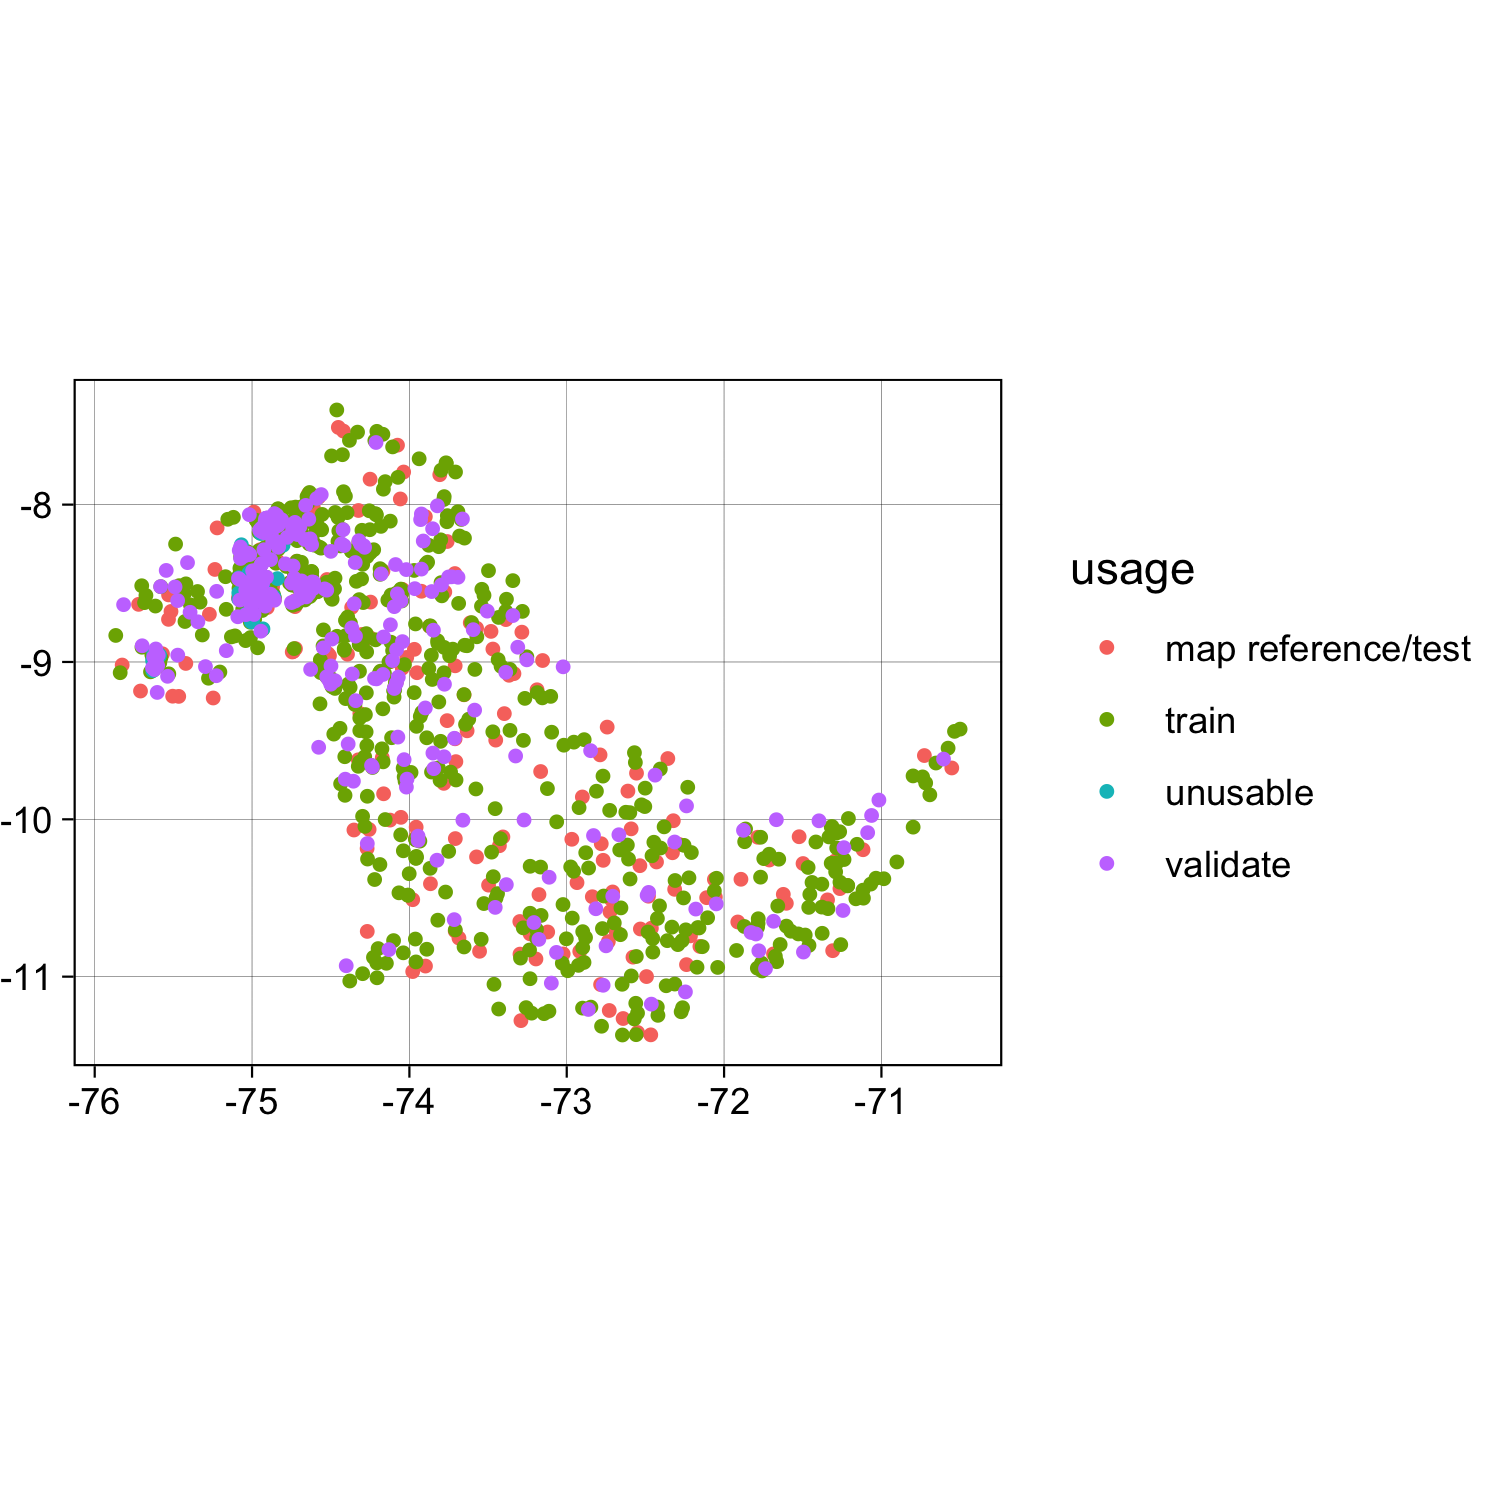

In [37]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)
ggplot(full_samplef) + 
  geom_sf(aes(color = usage), size = 1) + 
  theme_linedraw()

## Dataset key
- id = Sample ID (corrected after randomized ordering)
- clust = Stratification cluster (0, 1, 11 [previously digitized areas])
- use = Usability of sample: 1 = suitable for training/validation/map reference, 0 = unusable
- usage = Categorized into training, validation, and map reference (test) splits
- class2: Classification by consensus on simplified oil palm class
- agree2: Agreement per observation, assessed using simplified classification scheme
- class: Consensus classification using all four classes (not recommended for modelling)
- agree: Agreement per observation, assessed using full classification scheme
- cl1: Labeller 1's sample
- cl2: Labeller 2 sample
- cl3: Labeller 3 sample